# A quick starspot tutorial: measuring the rotation period of a TESS star

In this tutorial we'll measure the rotation period of a TESS target. First we'll download and plot a light curve using the lightkurve package.

In [27]:
import numpy as np
import lightkurve as lk

starname = "TIC 10863087"
lcf = lk.search_lightcurve(starname).download()

/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/lightkurve-2.0a2.dev0-py3.7.egg/lightkurve/search.py:221: LightkurveWarning: Warning: 3 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning)


In [28]:
lc = lcf.flux
lc.scatter(alpha=.5, s=.5);

AttributeError: 'Quantity' object has no 'scatter' member

First of all, let's remove the flares which will limit our ability to measure a rotation period by sigma clipping.

In [3]:
import starspot as ss
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Calculate the median so that we can median-normalize.
med = np.median(lc.flux.value)

# Do an initial sigma clip to remove big outliers.
m = ss.sigma_clip(lc.flux.value/med - 1, nsigma=6)
x, y, yerr = lc.time.value[m], lc.flux.value[m]/med - 1, lc.flux_err.value[m]/med

# Then a sigma clip using a Sav-Gol filter for smoothing
mask, smooth = ss.filter_sigma_clip(x, y, window_length=199)

time, flux, flux_err = x[mask], y[mask], yerr[mask]

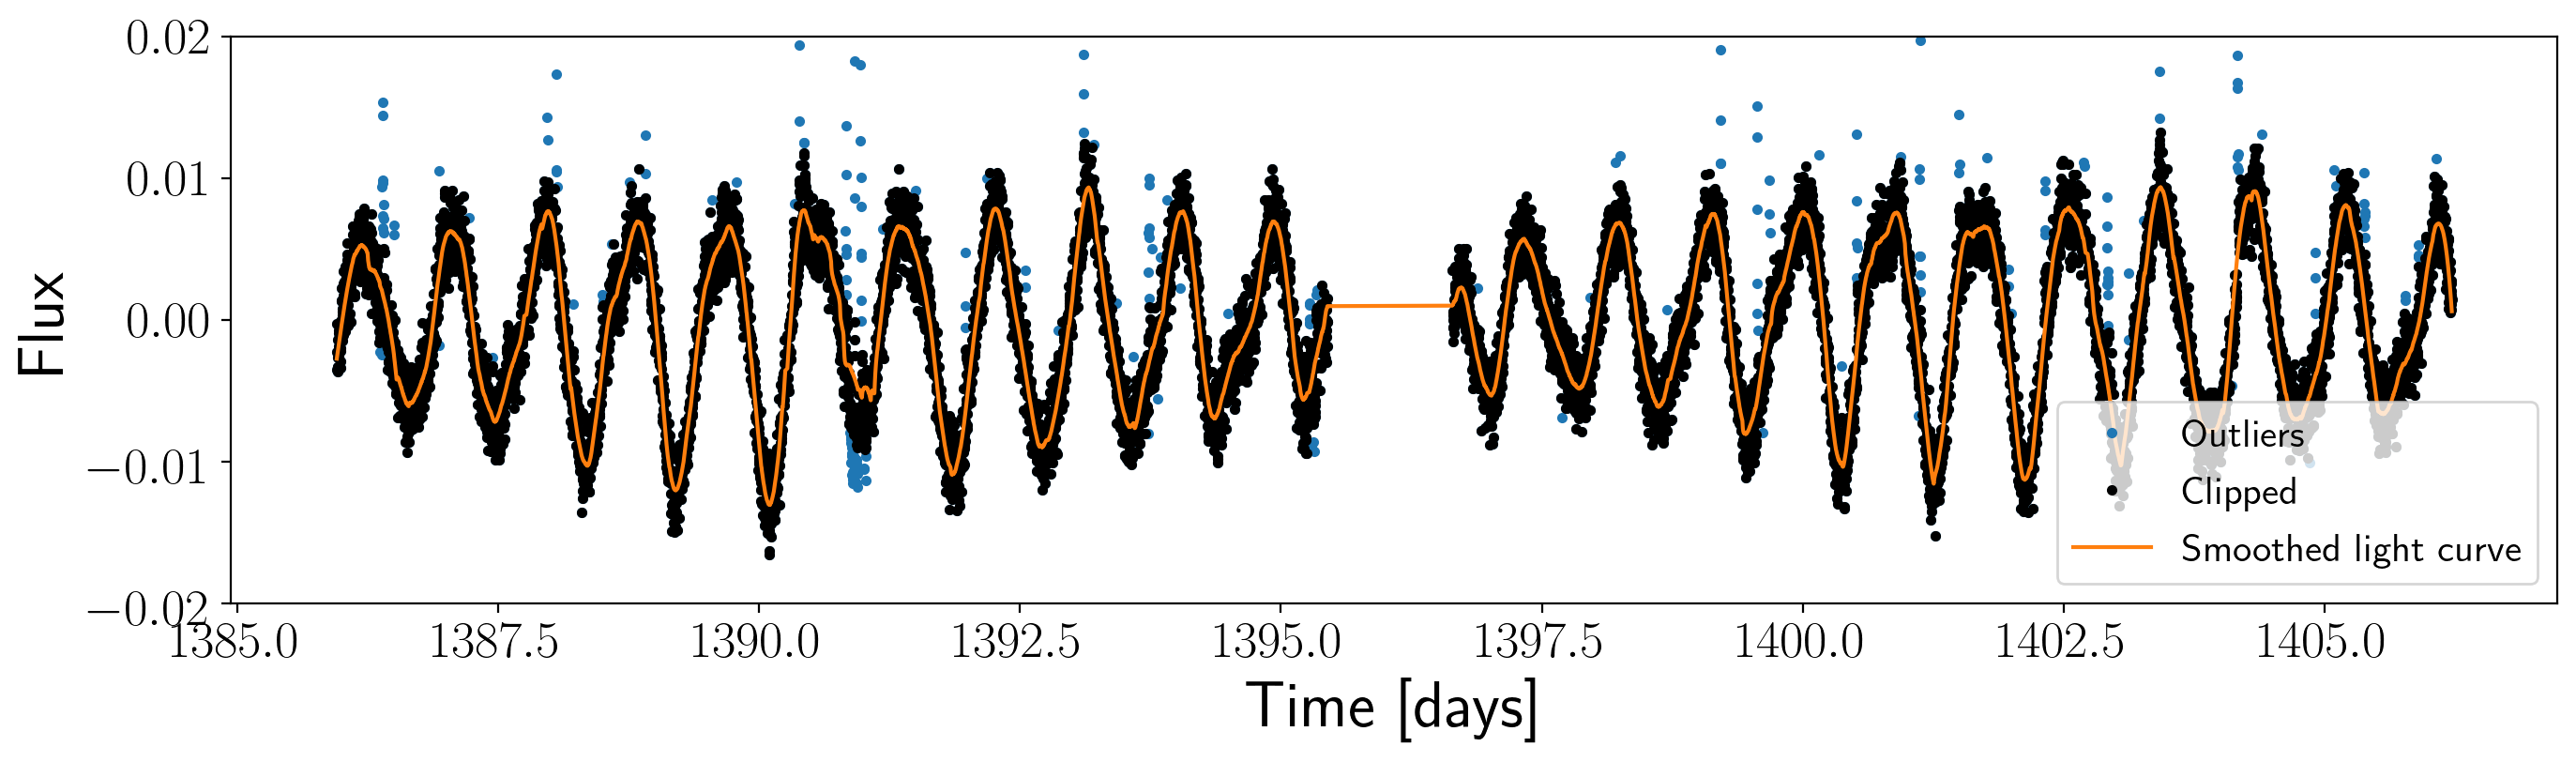

In [5]:
plt.figure(figsize=(16, 4), dpi=200)
plt.plot(lc.time.value, lc.flux.value/med-1, ".", label="Outliers", rasterized=True)
plt.plot(time, flux, "k.", label="Clipped")
plt.plot(x, smooth, label="Smoothed light curve")
plt.xlabel("Time [days]")
plt.ylabel("Flux");
plt.ylim(-.02, .02);
plt.legend(loc="lower right", fontsize=15);

Next, let's import starspot and set up a RotationModel object.

In [6]:
import starspot as ss

rotate = ss.RotationModel(time, flux, flux_err)

We can also plot the light curve using the lc_plot function in starspot:

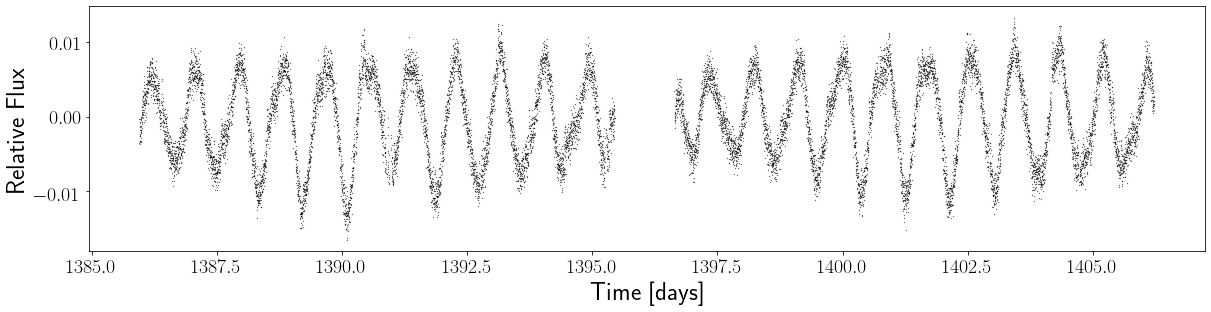

In [7]:
rotate.lc_plot()

To measure a rotation period for this star using a Lomb-Scargle (LS) periodogram we could use the astropy implementation of the Lomb-Scargle periodogram ([docs](https://docs.astropy.org/en/stable/timeseries/lombscargle.html)). starspot has a very basic wrapper to this algorithm built-in with some predefined parameter choices. A Lomb-Scargle periodogram is an algorithm fits a single sinusoid to the light curve and reports the squared amplitude of the sinusoid over a range of frequencies (1/periods). Here's the simplest way to use the LS periodogram in starspot.

In [8]:
ls_period = rotate.ls_rotation()
ls_period

0.860808017577187

This implements the following wrapper to the astropy LS periodogram.

In [9]:
import astropy.timeseries as apt

# Make sure your flux array does not contain any NaNs
m = np.isfinite(flux)
time, flux, flux_err = time[m], flux[m], flux_err[m]

max_period = 50  # Default starspot value
min_period = .5  # Default starspot value

# Define a frequency array. This is how it's defined in starspot.
freq = np.linspace(1./max_period, 1./min_period, 100000)
ps = 1./freq

# Calculate the LS periodogram
power = apt.LombScargle(time, flux).power(freq)

# Extract all the peaks from the periodogram
peaks = np.array([i for i in range(1, len(ps)-1) if power[i-1] < power[i] and power[i+1] < power[i]])

# If no peaks were found, return 0.
if len(peaks) == 0:
    ls_period = 0
else:
    ls_period = ps[power == max(power[peaks])][0]

If you want more control over how to implement your periodogram, I recommend using the astropy algorithm directly, or the exoplanet wrapper to it (below). If you want to, you can then feed your power and frequency arrays and LS rotation period back into starspot like this:

In [10]:
ls_period = rotate.ls_rotation(input_freq=freq, input_power=power, input_ls_period=ls_period)
ls_period

0.860808017577187

Using the exoplanet wrapper to the astropy LS periodogram allows you to easily add a high pass filter to your periodogram ([docs](https://docs.exoplanet.codes/en/stable/user/api/#estimators)). 

In [11]:
import exoplanet as xo

# Calculate a LS period with a high-pass filter at 15 days using exoplanet.
results = xo.estimators.lomb_scargle_estimator(time, flux, max_peaks=1, min_period=.5,
                                               max_period=50, samples_per_peak=50,
                                               filter_period=15)

freq, power = results["periodogram"]
peak = results["peaks"][0]
ls_period = peak["period"]

In [12]:
ls_period = rotate.ls_rotation(input_freq=freq, input_power=power, input_ls_period=ls_period)
ls_period

0.8608223500179895

We measured a rotation period of 0.86 days by finding the period of the highest peak in the periodogram. Feeding the frequency and power arrays back to starspot lets you use some of the built-in plots. Let's plot the periodogram.

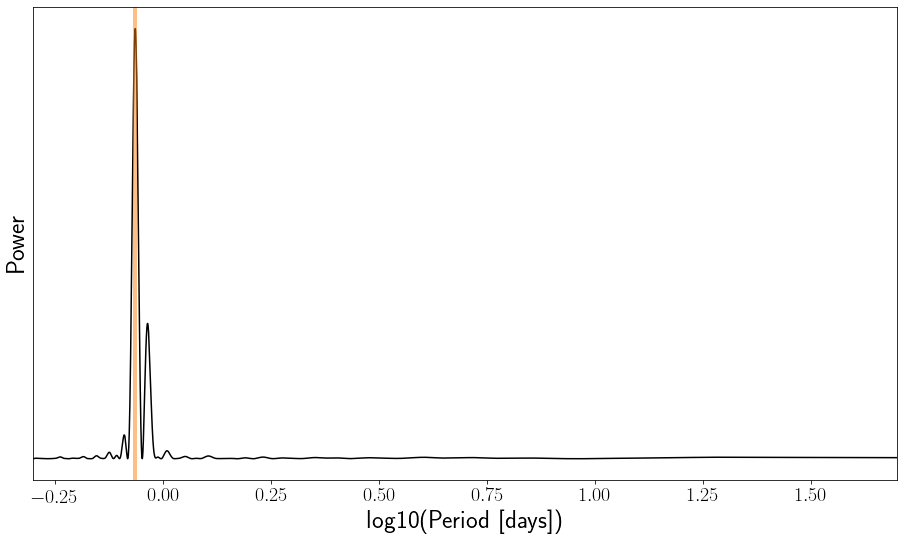

In [13]:
rotate.ls_plot();

Now let's calculate an ACF and measure a rotation period by finding the highest peak.

In [14]:
tess_cadence = 1./24./30.  # This is a TESS 2 minute cadence star.
acf_period = rotate.acf_rotation(tess_cadence)

In [15]:
acf_period

0.8749999999999999

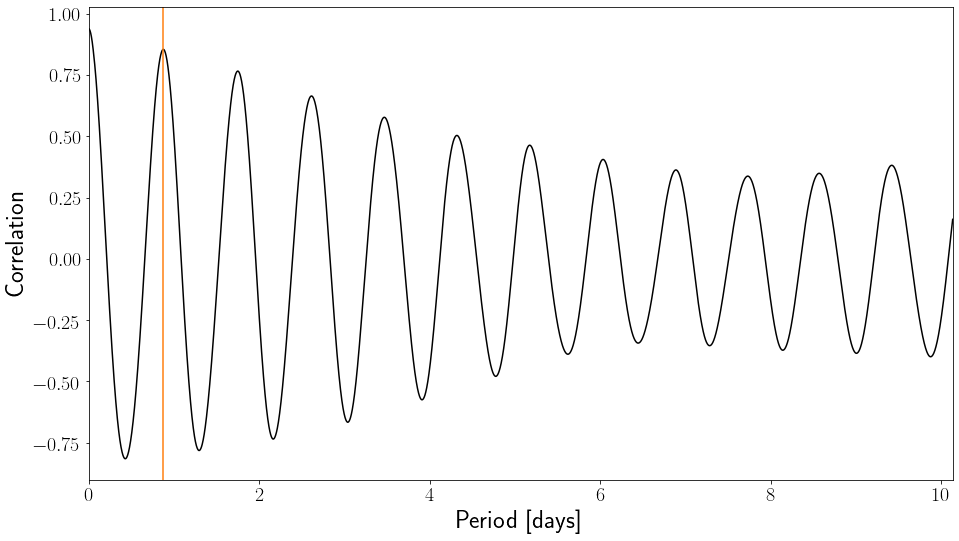

In [16]:
rotate.acf_plot();

This method estimates a period of 0.88 days, which is very close to the periodogram method. It is important to note that the LS periodogram method and the ACF method are not independent, i.e. if you measure a certain rotation period with one, you are likely to measure the same rotation period with the other. These two methods should not be used as independent 'checks' to validate a measured rotation period.

Now, let's calculate a rotation period using the Phase Dispersion Minimization algorithm of [Stellingwerf (1978)](https://ui.adsabs.harvard.edu/abs/1978ApJ...224..953S/abstract). This function will return the period with the lowest phase dispersion. It also fits a Gaussian to the dispersion curve in order to estimate the uncertainty. This Gaussian is shown in blue in the lower panel.

In [17]:
period_grid = np.linspace(.1, 2, 1000)

# Set the number of bins to 10
pdm_period, period_err = rotate.pdm_rotation(period_grid, pdm_nbins=10)
print(pdm_period, period_err)

100%|██████████| 1000/1000 [00:06<00:00, 165.37it/s]

0.8607607607607607 0.011651758040500825


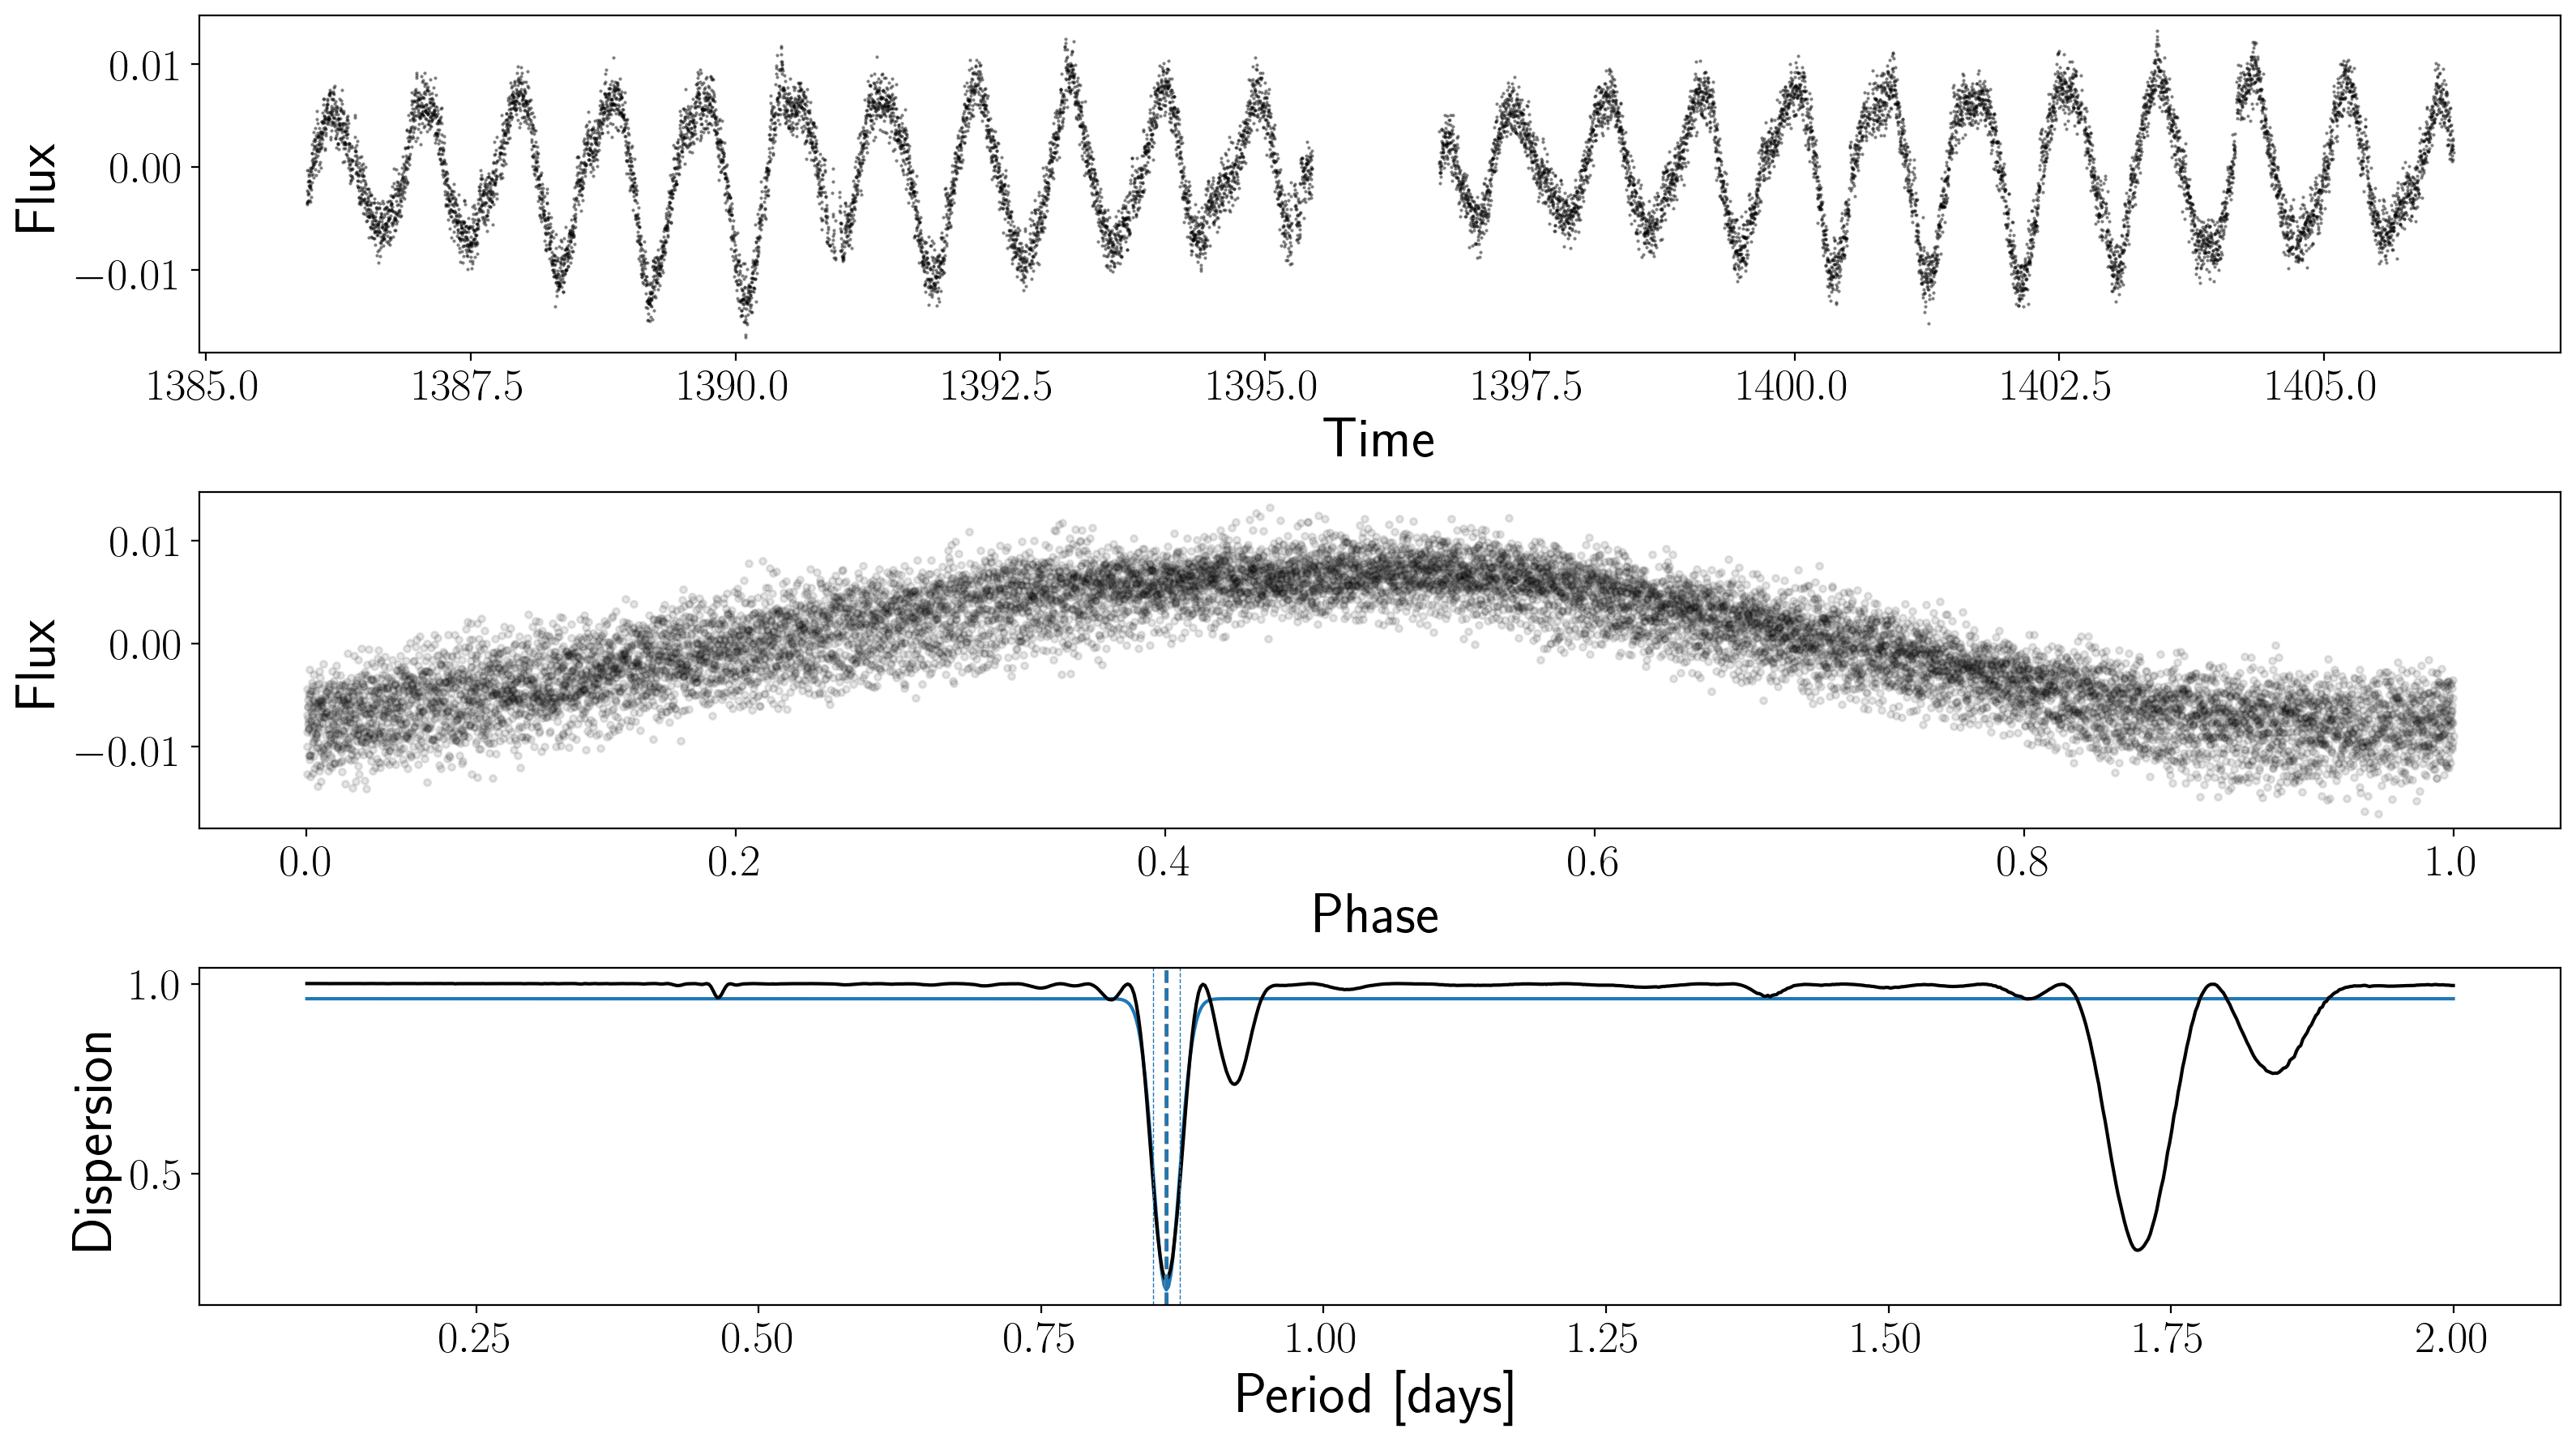

In [18]:
rotate.pdm_plot();

Now we can plot all these methods together in a single figure, with the light curve folded on the three different periods using big_plot:

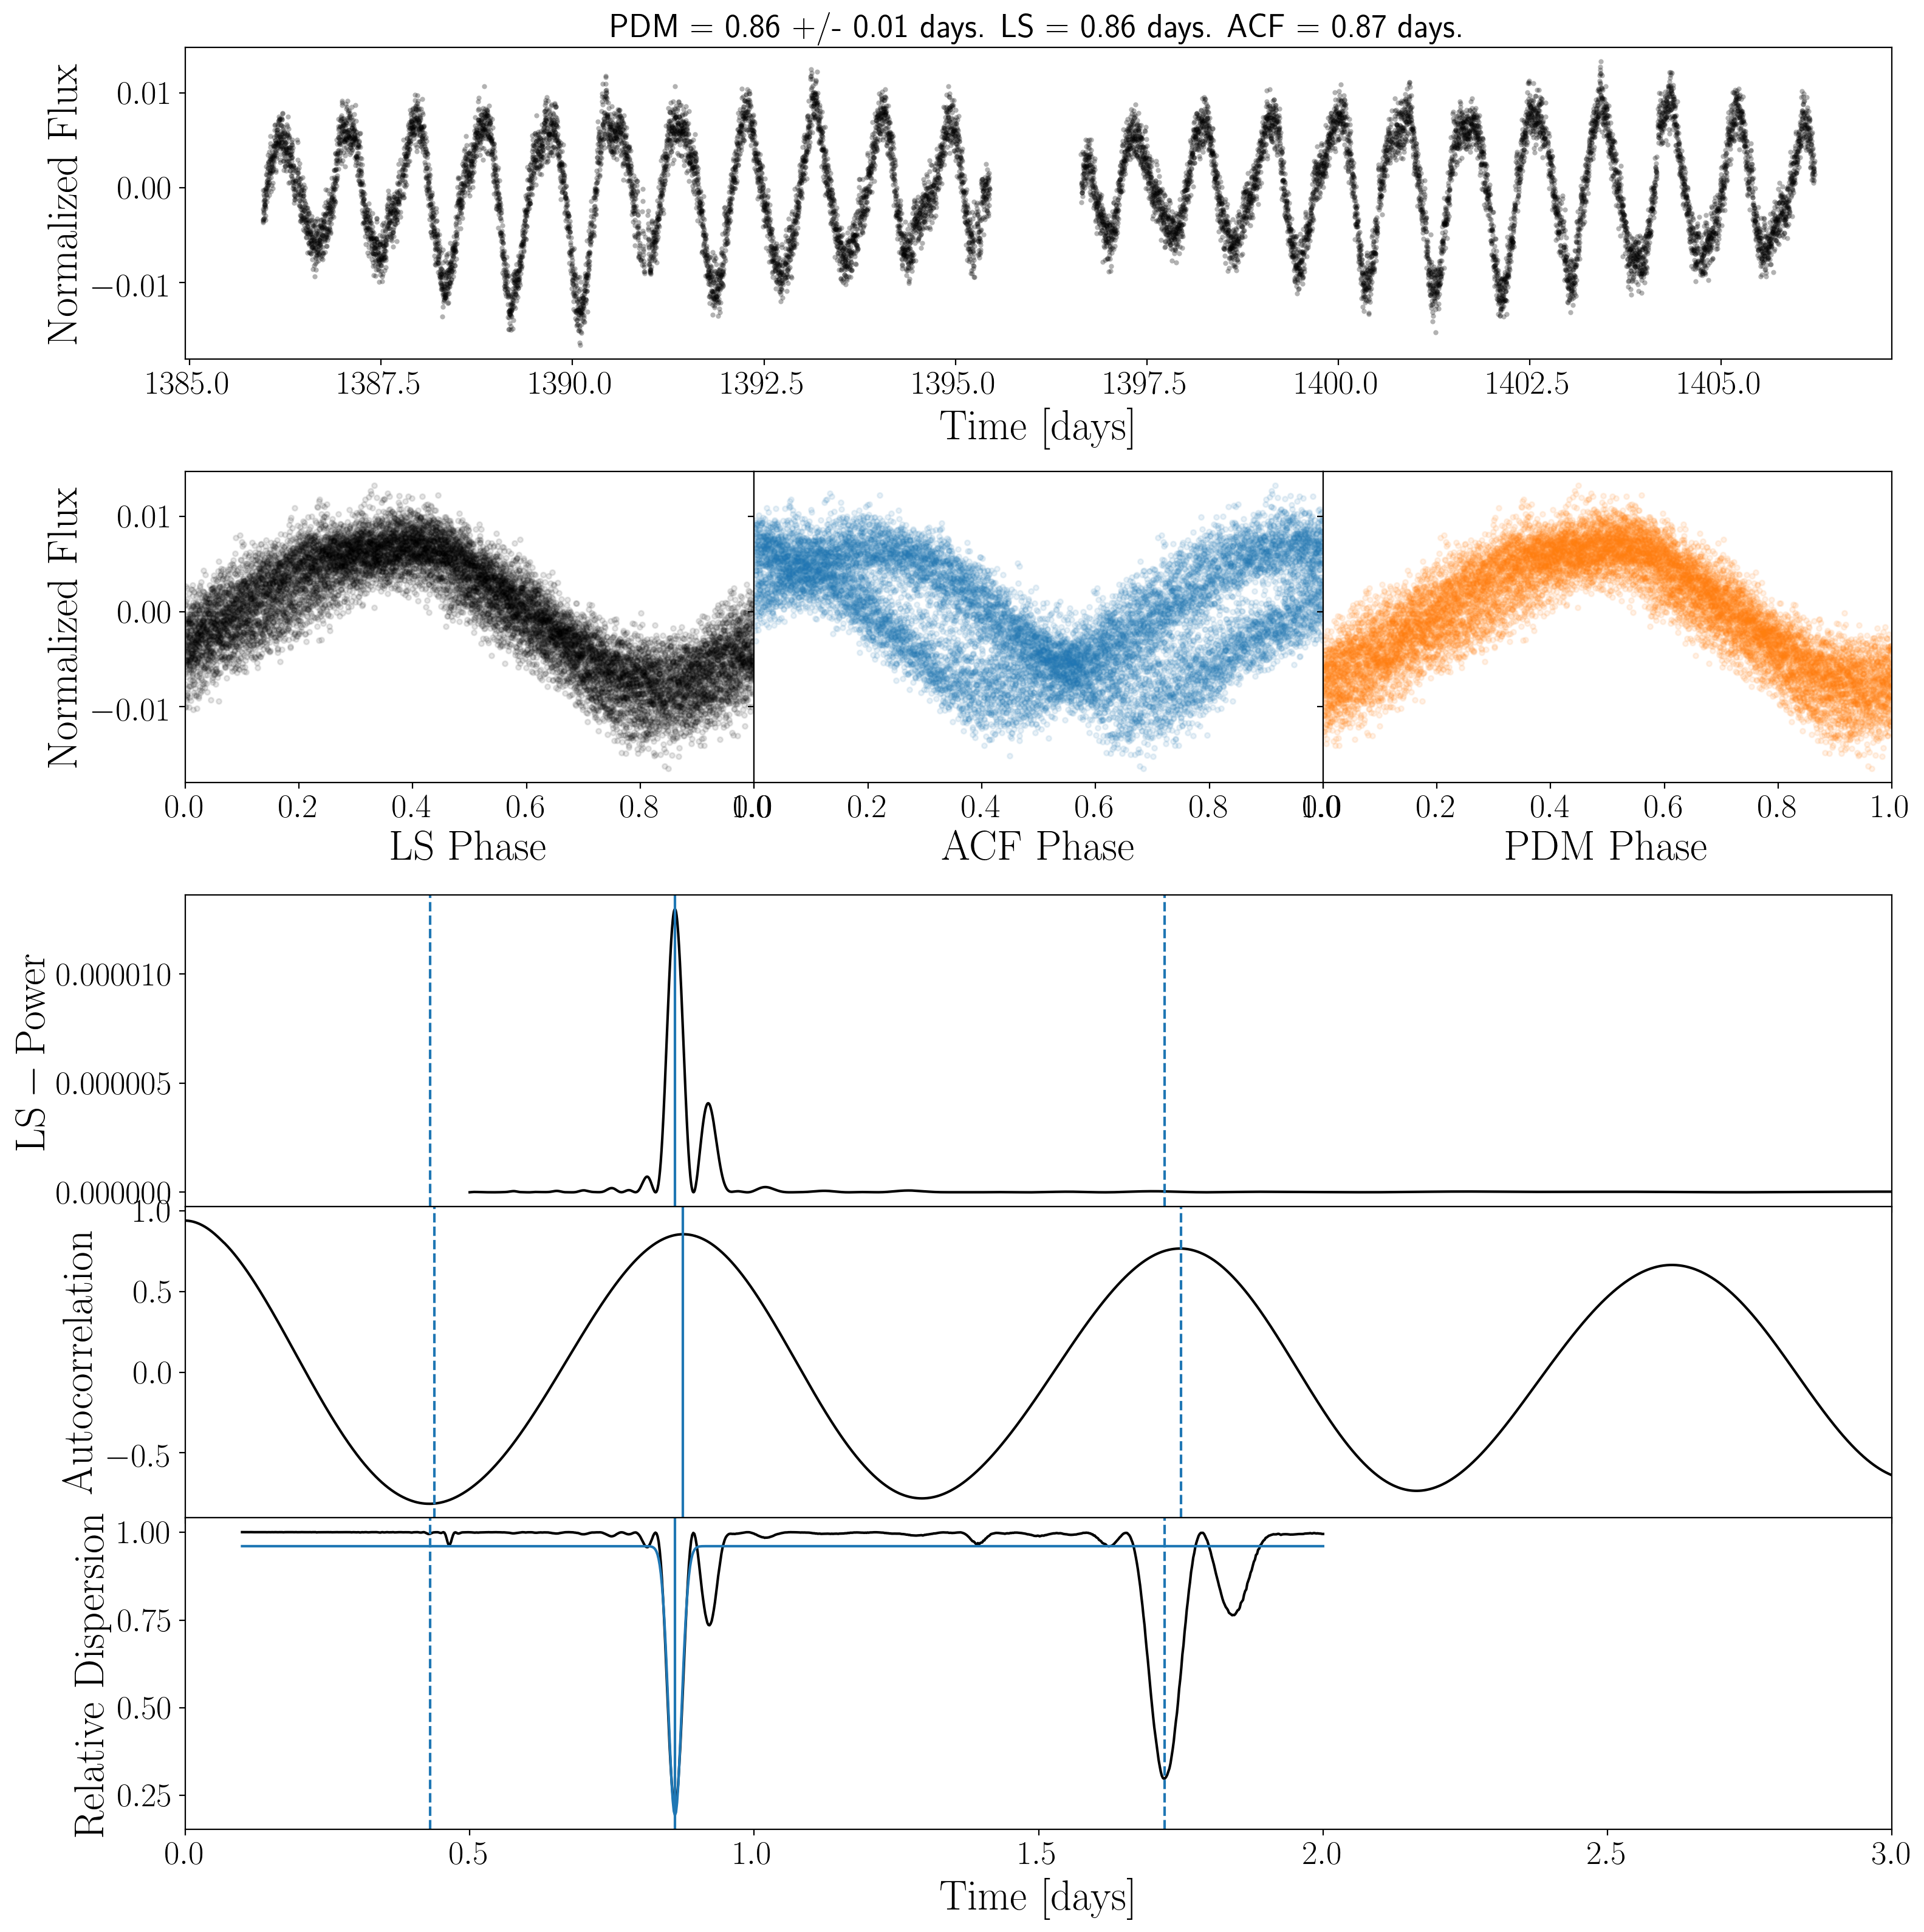

In [19]:
# Provide the list of methods and xlimits for the bottom panels
fig = rotate.big_plot(["ls", "acf", "pdm"], method_xlim=(0, 3));

The Lomb-Scargle periodogram, ACF, and phase dispersion arrays are accessible via:

In [20]:
# Lomb-Scargle periodogram
period_array = 1./rotate.freq
power_array = rotate.power

# Autocorrelation function
ACF_array = rotate.acf
lag_array = rotate.lags

# Phase-dispersion minimization
phi_array = rotate.phis  # The 'dispersion' plotted in the lower panel above.
period_grid = period_grid  # We already defined this above.

These could come in handy because it might be useful to calculate various peak statistics. We can do that with the get_peak_statistics() function, e.g.

In [21]:
# Get peak positions and heights, in order of highest to lowest peak. 
peak_positions, peak_heights = ss.get_peak_statistics(1./rotate.freq, rotate.power)

# This is the period of the highest peak (which is the default LS period)
print(peak_positions[0])

0.8607059393468749


For the ACF peak statistics, we might choose either the highest peak as the period (default in starspot):

In [22]:
# Get peak positions and heights, in order of highest to lowest peak. 
acf_peak_positions, acf_peak_heights = ss.get_peak_statistics(rotate.lags,
                                                              rotate.acf,
                                                              sort_by="height")
print(acf_peak_positions[0])

0.8749999999999999


Or the first peak:

In [23]:
# Get peak positions and heights, in order of lags. 
acf_peak_positions, acf_peak_heights = ss.get_peak_statistics(rotate.lags,
                                                              rotate.acf,
                                                              sort_by="position")
print(acf_peak_positions[0])

0.8749999999999999


In this example the first and the highest peak are the same.

If you're interested in using Gaussian processes to measure stellar rotation periods, check out [exoplanet](https://docs.exoplanet.codes/en/stable/) or [celerite](https://docs.exoplanet.codes/en/stable/).

In [25]:
# from scipy import signal

# t = np.linspace(-1, 1, 200, endpoint=False)
# sig  = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)
# widths = np.arange(1, 31)
# cwtmatr = signal.cwt(sig, signal.morlet, widths)
# print(type(cwtmatr))
# # plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
# #            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())